# Vocabulary

In [20]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from tqdm.autonotebook import tqdm
#import pandas as pd
import mysql.connector
import codecs
codecs.register(lambda name: codecs.lookup('utf8') if name == 'utf8mb4' else None)
import conllu
from nltk import ngrams

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [22]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd='password',
  database="small_commits_db",
  charset='utf8mb4')

mycursor = mydb.cursor()

### top languages

In [23]:
mycursor.execute('SELECT DISTINCT count(id), language from R GROUP BY language')
languages = {}
for i in mycursor.fetchall():
    if i[0] > 1000 and i[1] is not None:
        languages[i[1]] = (i[0], len(languages),)

In [24]:
for i in sorted(languages, key=languages.get, reverse=True):
    print (i, languages[i])

JavaScript (17480, 7)
Python (8689, 10)
Java (8357, 6)
Objective-C (3890, 8)
PHP (3540, 9)
Go (3496, 4)
C++ (3449, 2)
Ruby (3379, 11)
C (3202, 0)
Swift (2222, 13)
HTML (2150, 5)
C# (2019, 1)
Shell (1770, 12)
CSS (1675, 3)
TypeScript (1145, 14)


### frequency dictinonary

In [6]:
def yield_lemma_pos():
    mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id')
    text = mycursor.fetchone()
    #print (text)
    while text:
        doc = conllu.parse(text[0])
        for sent in doc:
            yield text[1], [i['lemma']+'_'+i['upostag'] for i in sent.tokens]
        text = mycursor.fetchone()

In [7]:
dictionary = defaultdict(lambda: [0]*(len(languages)+1))
#commits = CommitIterator2()
for item in tqdm(yield_lemma_pos()):
    #print (sent)
    lang, sent = item
    try:
        lang = languages[lang][1]
    except:
        lang = -1
    for word in sent:
        item = word.replace('_','')
        if item.isalnum() and not item.isnumeric():
            dictionary[word][lang] += 1

In [8]:
with open('frequency_dict.csv', 'w') as f:
    header = ['Lemma', 'POS']+[i for i in sorted(languages, key=lambda x: languages[x][1])]+['Other']
    f.write('\t'.join(header)+'\n')
    for key in sorted(dictionary, key=lambda x: sum(dictionary[x]), reverse=True):
        word_and_pos = key.split('_')
        pos = word_and_pos[-1]
        word = '_'.join(word_and_pos[:-1])
        row = [word, pos]+[str(i) for i in dictionary[key]]
        f.write('\t'.join(row)+'\n')

In [9]:
! head -n 3 frequency_dict.csv

Lemma	POS	C	C#	C++	CSS	Go	HTML	Java	JavaScript	Objective-C	PHP	Python	Ruby	Shell	Swift	TypeScript	Other
the	DET	248432	9350	66342	2017	51	1485	105974	30922	8519	22413	66902	201987	1805	53	0	70129
be	AUX	147961	5950	52590	724	29	872	62814	17357	4788	14869	50191	144521	1171	27	0	45003


### number of words in corpora

In [11]:
total = 0
for item in tqdm(yield_lemma_pos()):
    #print (sent)
    lang, sent = item
    total += len(sent)
total

37654156

In [12]:
len(dictionary)

867902

In [13]:
37654156/len(dictionary)

43.38526239137598

# top ngrams

In [ ]:
dontttake = set([('PUNCT', 'PUNCT')])

In [6]:
def ngram_list(n=2):
    dictionary = defaultdict(lambda: [0]*(len(languages)+1))
    for item in tqdm(yield_lemma_pos()):
        lang, sent = item
        
        try:
            lang = languages[lang][1]
        except:
            lang = -1
        ng = ngrams(sent, n)
        for ngram in ng:
            if 'PUNCT' not in ' '.join(ngram):
                dictionary[ngram][lang] += 1
    
    with open('./results_small/{}grams.csv'.format(n), 'w') as f:
        header = ['Ngram']+[i for i in sorted(languages, key=lambda x: languages[x][1])]+['Other']
        f.write('\t'.join(header)+'\n')
        for key in sorted(dictionary, key=lambda x: sum(dictionary[x]), reverse=True):
            if sum(dictionary[key]) >= 5:
                word = ' '.join(key)
                #pos = word_and_pos[-1]
                row = [word]+[str(i) for i in dictionary[key]]
                f.write('\t'.join(row)+'\n')

In [19]:
ngram_list(n=2)

In [ ]:
dictionary = defaultdict(int)
k = 0
with open('/home/dkbrz/GitHub/Git_Commits/results_small/2grams.csv') as f:
    for line in f:
        if k != 0:
            ngram = tuple([i.split('_')[-1] for i in line.split('\t')[0].split()])
            summ = sum(int(i) for i in line.split('\t')[1:])
            dictionary[ngram] += summ
        else:
            k += 1
for key in sorted(dictionary, key=dictionary.get, reverse=True):
    print (key, dictionary[key])

In [24]:
ok_2 = set([('NOUN', 'NOUN'), ('ADJ', 'NOUN'), ('VERB', 'NOUN'), ('VERB', 'ADP'), ('AUX', 'VERB'), 
          ('ADV', 'VERB'), ('NOUN', 'VERB'),
          ('ADP', 'NOUN'), ('VERB', 'ADJ'),  ('VERB', 'ADV')])

In [25]:
k = 0
with open('/home/dkbrz/GitHub/Git_Commits/results_small/2grams.csv') as fin, \
    open('./results_small/2grams_filtered.csv', 'w') as fout:
    for line in fin:
        if k != 0:
            ngram = tuple([i.split('_')[-1] for i in line.split('\t')[0].split()])
            if ngram in ok_2:
                fout.write(line)
        else:
            fout.write(line)
            k += 1

In [26]:
ngram_list(n=3)

In [ ]:
dictionary = defaultdict(int)
k = 0
with open('/home/dkbrz/GitHub/Git_Commits/results_small/3grams.csv') as f:
    for line in f:
        if k != 0:
            ngram = tuple([i.split('_')[-1] for i in line.split('\t')[0].split()])
            summ = sum(int(i) for i in line.split('\t')[1:])
            dictionary[ngram] += summ
        else:
            k += 1
for key in sorted(dictionary, key=dictionary.get, reverse=True):
    if 'PUNCT' not in key:
        print (key, dictionary[key])

In [11]:
ok_3 = set([
    ('NOUN', 'NOUN', 'NOUN'), ('VERB', 'DET', 'NOUN'), ('AUX', 'PART', 'VERB'), ('NOUN', 'ADP', 'NOUN'),
    ('NOUN', 'PART', 'VERB'), ('VERB', 'PART', 'VERB'), ('VERB', 'ADJ', 'NOUN'), ('VERB', 'NOUN', 'NOUN'),
    ('VERB', 'ADP', 'NOUN'), ('ADJ', 'NOUN', 'NOUN'), ('AUX', 'AUX', 'VERB'), ('NOUN', 'AUX', 'VERB'),
    ('AUX', 'ADV', 'VERB')
])

In [12]:
k = 0
with open('/home/dkbrz/GitHub/Git_Commits/results_small/3grams.csv') as fin, \
    open('./results_small/3grams_filtered.csv', 'w') as fout:
    for line in fin:
        if k != 0:
            ngram = tuple([i.split('_')[-1] for i in line.split('\t')[0].split()])
            if ngram in ok_3:
                fout.write(line)
        else:
            fout.write(line)
            k += 1

In [7]:
ngram_list(n=4)

In [ ]:
dictionary = defaultdict(int)
k = 0
with open('/home/dkbrz/GitHub/Git_Commits/results_small/4grams.csv') as f:
    for line in f:
        if k != 0:
            ngram = tuple([i.split('_')[-1] for i in line.split('\t')[0].split()])
            summ = sum(int(i) for i in line.split('\t')[1:])
            dictionary[ngram] += summ
        else:
            k += 1
for key in sorted(dictionary, key=dictionary.get, reverse=True):
    if 'PUNCT' not in key:
        print (key, dictionary[key])

In [17]:
ok_4 = set([
    ('NOUN', 'NOUN', 'NOUN', 'NOUN'), ('VERB', 'DET', 'NOUN', 'ADP'),
    ('ADP', 'DET', 'ADJ', 'NOUN'), ('NOUN', 'ADP', 'DET', 'NOUN'), ('VERB', 'NOUN', 'ADP', 'NOUN'),
    ('VERB', 'DET', 'ADJ', 'NOUN'), ('ADP', 'DET', 'NOUN', 'NOUN'), ('AUX', 'PART', 'VERB', 'ADP'),
    ('NOUN', 'ADP', 'NOUN', 'NOUN'), ('NOUN', 'NOUN', 'ADP', 'NOUN'), ('VERB', 'DET', 'NOUN', 'NOUN'),
    ('NOUN', 'ADP', 'ADJ', 'NOUN'), ('ADJ', 'NOUN', 'ADP', 'NOUN'),
    ('AUX', 'VERB', 'PART', 'VERB')
])

In [18]:
k = 0
with open('/home/dkbrz/GitHub/Git_Commits/results_small/4grams.csv') as fin, \
    open('./results_small/4grams_filtered.csv', 'w') as fout:
    for line in fin:
        if k != 0:
            ngram = tuple([i.split('_')[-1] for i in line.split('\t')[0].split()])
            if ngram in ok_4:
                fout.write(line)
        else:
            fout.write(line)
            k += 1

### commit length in sentences

In [41]:
def yield_sentences(out='gensim', mode='lemma', joint=True):
    mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id')
    text = mycursor.fetchone()
    #print (text)
    while text:
        doc = conllu.parse(text[0])
        #print (doc)
        yield text[1], doc
        text = mycursor.fetchone()

In [42]:
dictionary = defaultdict(lambda: [0]*(len(languages)+1))
for item in tqdm(yield_sentences(joint=False)):
    lang, doc = item
    if type(doc) == list:
        length = len(doc)
    else:
        length = 1
    try:
        lang = languages[lang][1]
    except:
        lang = -1
    dictionary[length][lang] += 1

In [43]:
len(dictionary)

167

In [45]:
with open('./results_small/length_in_sentences.csv', 'w') as f:
    header = ['Ngram']+[i for i in sorted(languages, key=lambda x: languages[x][1])]+['Other']
    f.write('\t'.join(header)+'\n')
    for key in sorted(dictionary, key=lambda x: sum(dictionary[x]), reverse=True):
        word = str(key)
        #pos = word_and_pos[-1]
        row = [word]+[str(i) for i in dictionary[key]]
        f.write('\t'.join(row)+'\n')

In [282]:
df = pd.read_csv('./results_small/length_in_sentences.csv', sep='\t').sort_values(by='Ngram')
df['Total'] = df[['Ruby', 'C', 'Java', 'Other', 'C++', 'Python', 'JavaScript', 'PHP',
       'C#', 'Objective-C', 'HTML', 'CSS', 'Shell', 'Go', 'Swift']].sum(axis=1)
df = df.reindex_axis(sorted(df.columns, key=lambda x: df[x].sum(), reverse=True), axis=1)

In [283]:
df.sum(axis=0)

Total          2000280
Ruby            660621
C               245545
Java            234267
Other           218555
C++             195582
Python          195414
JavaScript      116946
PHP              75022
Ngram            26367
C#               24975
Objective-C      15666
HTML              7906
CSS               4671
Shell             4544
Go                 360
Swift              206
TypeScript           0
dtype: int64

In [284]:
ng = df['Ngram']

In [285]:
del df['TypeScript'], df['Ngram'], df['Go'], df['Swift']

In [286]:
df = df/df.sum()

In [287]:
df.index = ng
df.head()

,Total,Ruby,C,Java,Other,C++,Python,JavaScript,PHP,C#,Objective-C,HTML,CSS,Shell
Ngram,,,,,,,,,,,,,,
0,0.000226,0.000363,0.000187,0.000047,0.000119,0.000189,0.000031,0.000342,0.000133,0.000040,0.000702,0.000379,0.003211,0.001320
1,0.549952,0.596808,0.400745,0.322675,0.667562,0.504167,0.593059,0.776812,0.539388,0.640000,0.682369,0.759803,0.782274,0.713908
2,0.240206,0.242442,0.190222,0.355931,0.196308,0.270327,0.210072,0.150770,0.319946,0.227908,0.198200,0.176828,0.151788,0.180458
3,0.109755,0.099847,0.158537,0.191606,0.076150,0.105633,0.084943,0.044875,0.090720,0.085285,0.058471,0.044776,0.037037,0.050176
4,0.044165,0.031246,0.089071,0.069429,0.029727,0.049048,0.044173,0.014203,0.025592,0.026066,0.023554,0.010878,0.011775,0.021787


In [288]:
df.columns

Index(['Total', 'Ruby', 'C', 'Java', 'Other', 'C++', 'Python', 'JavaScript',
       'PHP', 'C#', 'Objective-C', 'HTML', 'CSS', 'Shell'],
      dtype='object')

In [289]:
df[1:10]

,Total,Ruby,C,Java,Other,C++,Python,JavaScript,PHP,C#,Objective-C,HTML,CSS,Shell
Ngram,,,,,,,,,,,,,,
1,0.549952,0.596808,0.400745,0.322675,0.667562,0.504167,0.593059,0.776812,0.539388,0.640000,0.682369,0.759803,0.782274,0.713908
2,0.240206,0.242442,0.190222,0.355931,0.196308,0.270327,0.210072,0.150770,0.319946,0.227908,0.198200,0.176828,0.151788,0.180458
3,0.109755,0.099847,0.158537,0.191606,0.076150,0.105633,0.084943,0.044875,0.090720,0.085285,0.058471,0.044776,0.037037,0.050176
4,0.044165,0.031246,0.089071,0.069429,0.029727,0.049048,0.044173,0.014203,0.025592,0.026066,0.023554,0.010878,0.011775,0.021787
5,0.023097,0.012178,0.053725,0.030871,0.012418,0.034006,0.032945,0.005866,0.009304,0.010250,0.012575,0.003542,0.003211,0.010343
6,0.011995,0.005955,0.033293,0.012998,0.006342,0.016510,0.016805,0.002642,0.004745,0.004605,0.006511,0.001012,0.002783,0.008363
7,0.006496,0.003321,0.020978,0.006032,0.003528,0.007557,0.007599,0.001505,0.002506,0.001682,0.003766,0.001518,0.002355,0.003081
8,0.003835,0.002071,0.013940,0.003052,0.002059,0.003809,0.003306,0.000727,0.001906,0.001041,0.002681,0.000506,0.001070,0.004401
9,0.002549,0.001402,0.009754,0.001797,0.001469,0.002337,0.001781,0.000710,0.001080,0.000761,0.001851,0.000506,0.000642,0.002641


In [290]:
df = df[1:10]

Text(0, 0.5, '% out of commits')

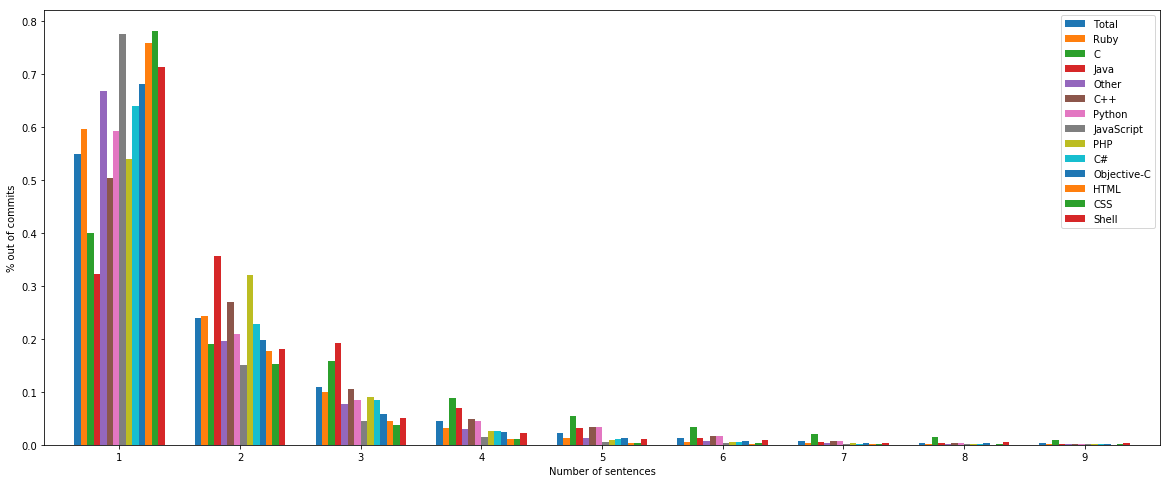

In [291]:
df.plot(figsize=(20, 8), kind='bar', rot=0, logy=False, width=0.75);
plt.xlabel('Number of sentences')
plt.ylabel('% out of commits')
#df.plot.bar(rot=0);

In [292]:
del df['Total']

In [ ]:
corr = np.corrcoef(df.T)

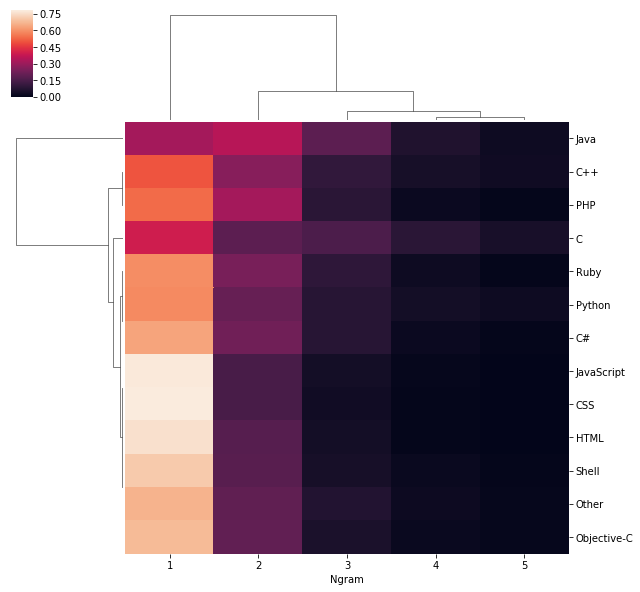

In [296]:
sns.clustermap(df[:5].T, metric="correlation")

### length of commit sentences 

In [80]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd='password',
  database="small_commits_db",
  charset='utf8mb4')

mycursor = mydb.cursor()

In [68]:
def yield_lengths(n=1):
    #mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id LIMIT 1000;')
    mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id')
    text = mycursor.fetchone()
    while text:
        doc = conllu.parse(text[0])
        if len(doc) == n:
            yield text[1], [len(i) for i in doc]
        text = mycursor.fetchone()

In [9]:
import seaborn as sns
labels = list(languages.keys())+['Other']

In [60]:
def plot_sentences(n=2):
    fig = plt.figure(figsize=(20,10))
    #ax1 = fig.add_subplot(221)
    #ax2 = fig.add_subplot(222)
    ax1 = plt.subplot2grid((2, 3), (0, 1), colspan=1)
    ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
    ax3 = plt.subplot2grid((2, 3), (1, 1), colspan=2)

    A, N, matrix_df = show_lengths(n=n)
    ax1 = sns.heatmap(A.T, annot=True, fmt=".3f", yticklabels=labels, xticklabels=list(range(1,n+1)), ax=ax1)
    ax1.set_xlabel('N-th sentence')
    ax1.set_ylabel('Language')
    ax1.set_title('Mean length of sentences in {}-senten commits'.format(n))
    
    _ = pd.DataFrame(data={'N':N})
    _.index = labels
    ax2 = sns.barplot(data=_.T, color='green', ecolor='black', orient='h', ax=ax2)
    ax2.set_xlabel('N of {}-senten commits'.format(n));
    ax2.set_title('N of {}-sentence commits'.format(n))
    
    ax3 = sns.boxplot(data=matrix_df, x=matrix_df['Language'], 
                      y=matrix_df['Length'], hue=matrix_df['N-th'], palette="Set1", showfliers=False, ax=ax3)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 90)
    ax3.set_xlabel('Language'.format(n))
    ax3.set_ylabel('Length'.format(n));
    
    plt.show()

In [11]:
def show_lengths(n=1):
    matrix_sum = np.zeros((n,len(languages)+1))
    matrix_df = []
    matrix_n = np.zeros(len(languages)+1)
    for item in tqdm(yield_lengths(n=n)):
        lang, lengths = item
        if len(lengths) == n:
            if lang not in languages:
                lang2 = 'Other'
            else:
                lang2 = lang
            try:
                lang = languages[lang][1]
            except:
                lang = -1
            for i in range(n):
                matrix_sum[i][lang] += lengths[i]
                matrix_df.append([lang2, str(i+1), lengths[i]])
            matrix_n[lang] += 1
    matrix_df = pd.DataFrame(matrix_df)
    matrix_df.columns = ['Language', 'N-th', 'Length']
    return matrix_sum/matrix_n, matrix_n, matrix_df

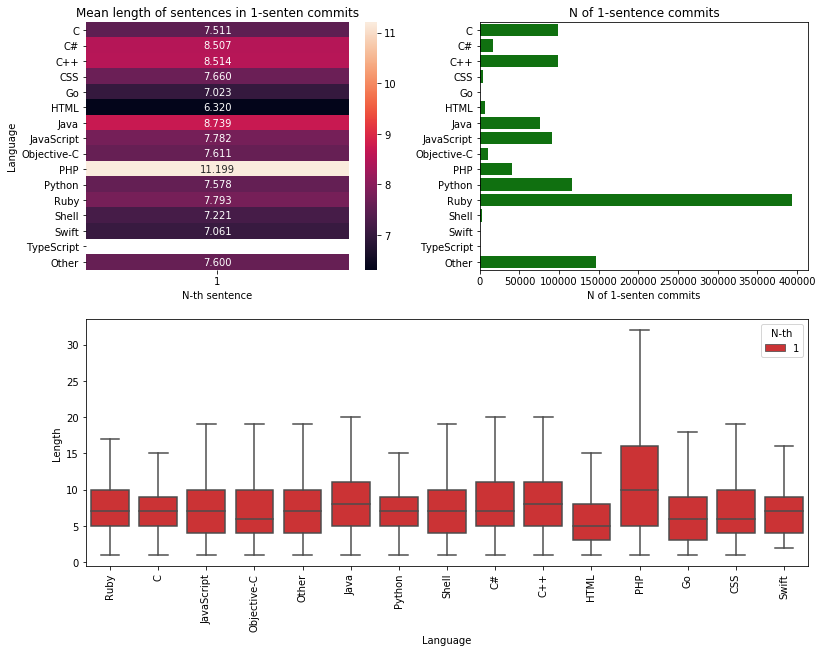

In [63]:
plot_sentences(n=1)

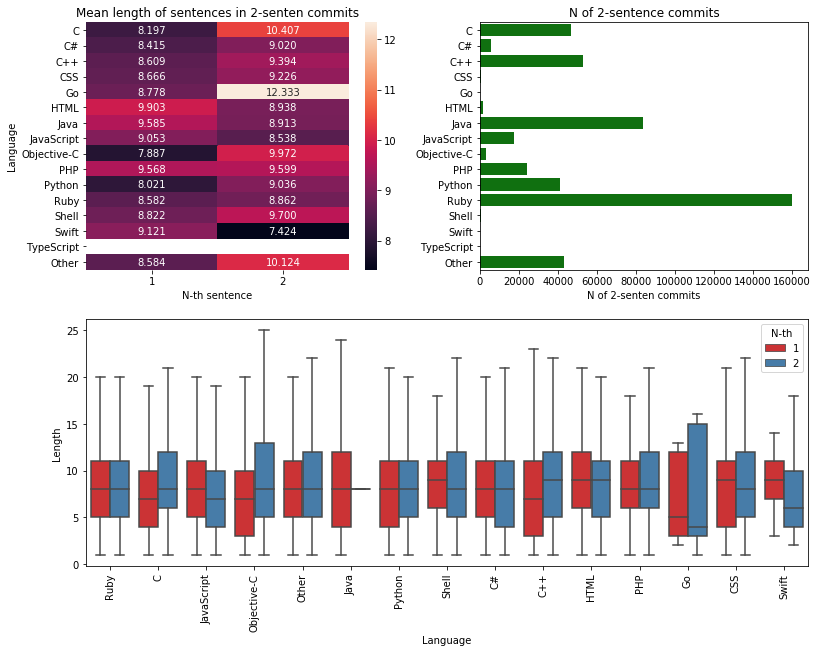

In [64]:
plot_sentences(n=2)

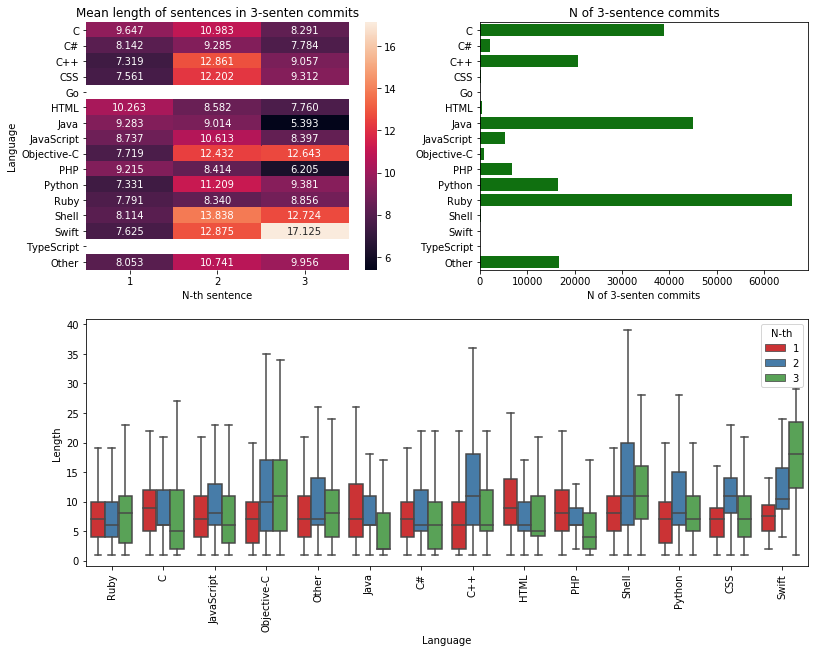

In [65]:
plot_sentences(n=3)

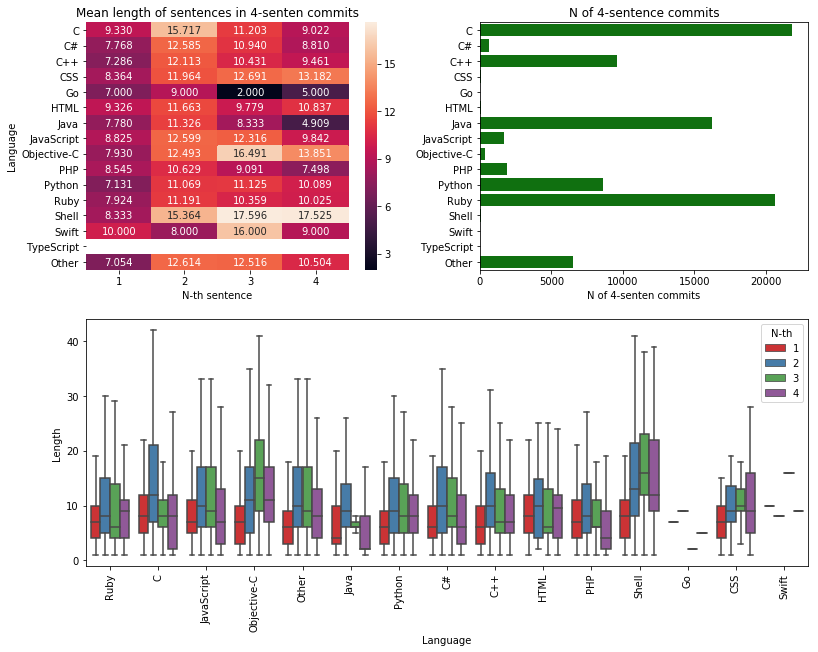

In [66]:
plot_sentences(n=4)

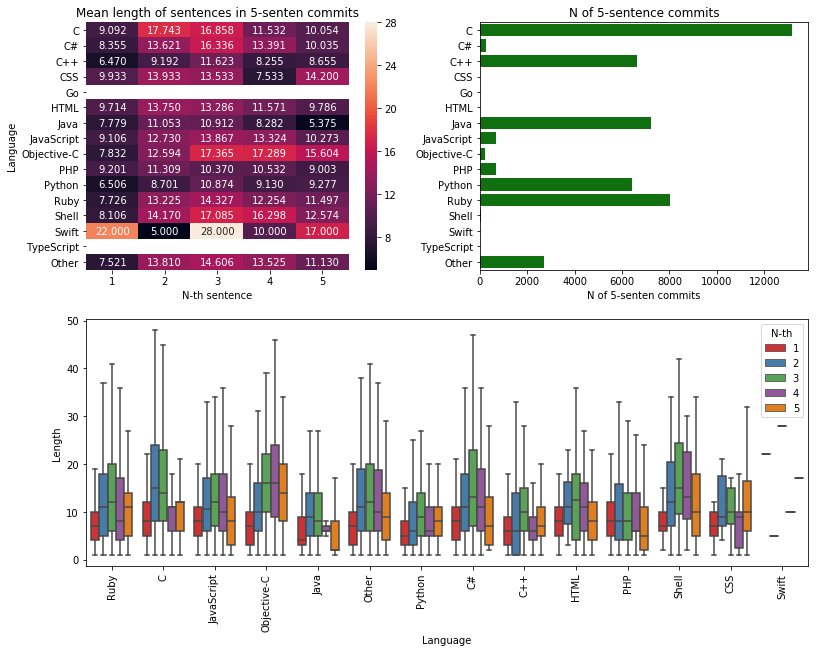

In [67]:
plot_sentences(n=5)

In [102]:
matrix_sum = np.zeros((2,len(languages)+1))
matrix_n = np.zeros((2,len(languages)+1))

matrix_sum[0] += 5
matrix_sum[1] += 3
matrix_n += 10
(matrix_sum/matrix_n)[0]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5])

In [105]:
def yield_lengths_one_vs_many():
    #mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id LIMIT 1000;')
    mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id')
    text = mycursor.fetchone()
    while text:
        doc = conllu.parse(text[0])
        if len(doc) > 1:
            yield text[1], [len(i) for i in doc]
        text = mycursor.fetchone()

def show_lengths_one_vs_many():
    matrix_sum = np.zeros((2,len(languages)+1))
    matrix_df = []
    matrix_n = np.zeros((2,len(languages)+1))
    for item in tqdm(yield_lengths_one_vs_many()):
        lang, lengths = item
        if len(lengths) > 1:
            if lang not in languages:
                lang2 = 'Other'
            else:
                lang2 = lang
            try:
                lang = languages[lang][1]
            except:
                lang = -1
            
            matrix_sum[0][lang] += lengths[0]
            matrix_df.append([lang2, '1', lengths[0]])
            matrix_n[0][lang] += 1
            
            for i in range(1, len(lengths)):
                matrix_sum[1][lang] += lengths[i]
                matrix_df.append([lang2, '2+', lengths[i]])
           
            matrix_n[1][lang] = matrix_n[1][lang] + len(lengths) - 1
    matrix_df = pd.DataFrame(matrix_df)
    matrix_df.columns = ['Language', 'N-th', 'Length']
    return matrix_sum/matrix_n, matrix_n[0,:], matrix_df

def plot_sentences_one_vs_many():
    fig = plt.figure(figsize=(20,10))
    #ax1 = fig.add_subplot(221)
    #ax2 = fig.add_subplot(222)
    ax1 = plt.subplot2grid((2, 3), (0, 1), colspan=1)
    ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
    ax3 = plt.subplot2grid((2, 3), (1, 1), colspan=2)

    A, N, matrix_df = show_lengths_one_vs_many()
    ax1 = sns.heatmap(A.T, annot=True, fmt=".3f", yticklabels=labels, xticklabels=list(range(1,2+1)), ax=ax1)
    ax1.set_xlabel('N-th sentence')
    ax1.set_ylabel('Language')
    ax1.set_title('Mean length of sentences in commits \nwith 2+ sentences')
    
    _ = pd.DataFrame(data={'N':N})
    _.index = labels
    ax2 = sns.barplot(data=_.T, color='green', ecolor='black', orient='h', ax=ax2)
    ax2.set_xlabel('Mean length of sentences in commits \nwith 2+ sentences');
    ax2.set_title('Mean length of sentences in commits \nwith 2+ sentences')
    
    ax3 = sns.boxplot(data=matrix_df, x=matrix_df['Language'], 
                      y=matrix_df['Length'], hue=matrix_df['N-th'], palette="Set1", showfliers=False, ax=ax3)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 90)
    ax3.set_xlabel('Language')
    ax3.set_ylabel('Length');
    
    plt.show()

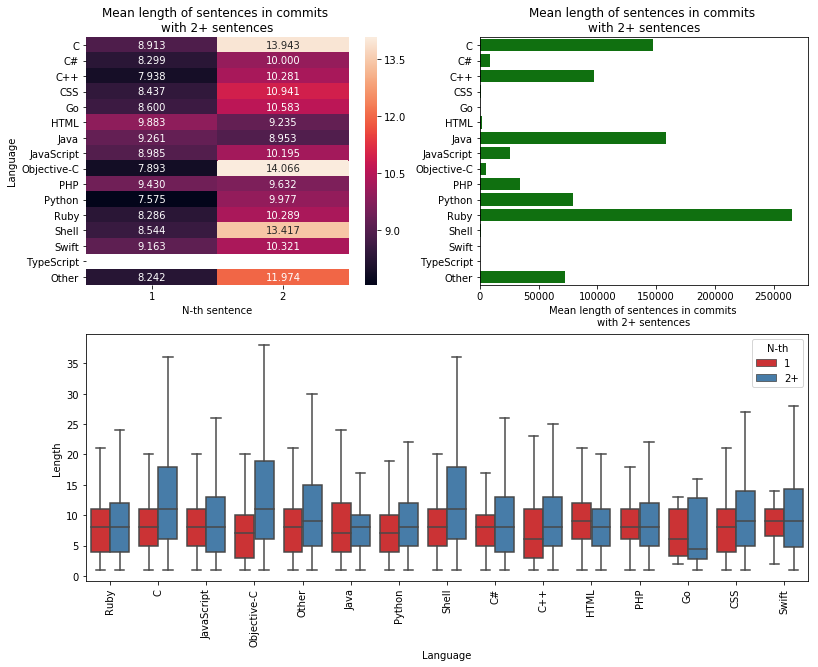

In [106]:
plot_sentences_one_vs_many()

## W2V

In [36]:
def yield_lemma():
    mycursor.execute('SELECT conllu, language FROM C LEFT JOIN R ON C.repo_id=R.gh_id')
    text = mycursor.fetchone()
    #print (text)
    while text:
        doc = conllu.parse(text[0])
        for sent in doc:
            yield text[1], [i['lemma'] for i in sent.tokens]
        text = mycursor.fetchone()

with open('./data/corpus_lemmas.txt', 'w') as f:
    for i in tqdm(yield_lemma()):
        f.write(' '.join(i[1]).strip().lower()+'\n')

In [27]:
import gensim

In [332]:
with open('./data/corpus.txt', 'w') as f:
    for i in tqdm(yield_lemma_pos()):
        f.write(' '.join(i[1]).strip()+'\n')

In [28]:
sentences = gensim.models.word2vec.LineSentence('./data/corpus_lemmas.txt')

In [42]:
del w2v

In [43]:
w2v = gensim.models.word2vec.Word2Vec(sentences, size=300,  window=5, seed=23,  workers=7, 
                                      min_count=10, sorted_vocab=1, iter=5)

KeyboardInterrupt: 

In [30]:
w2v.save('./data/models/w2v_lem_300_5_10m_5it')

In [41]:
w2v.wv.most_similar('unit', topn=30)

[('suite', 0.6276142597198486),
 ('acceptance', 0.5685091018676758),
 ('Unit', 0.5551984310150146),
 ('integration', 0.5482611656188965),
 ('casis', 0.5196164846420288),
 ('cas', 0.5145488977432251),
 ('stress', 0.4952530562877655),
 ('harness', 0.48755550384521484),
 ('functional', 0.4734092652797699),
 ('test', 0.4703044593334198),
 ('smoke', 0.4633328318595886),
 ('failing', 0.45024555921554565),
 ('assertion', 0.44032707810401917),
 ('flaky', 0.4388882517814636),
 ('Regression', 0.4387456774711609),
 ('scenario', 0.42811891436576843),
 ('runner', 0.4257950484752655),
 ('framework', 0.4246963858604431),
 ('spec', 0.42359915375709534),
 ('fixture', 0.4230601191520691),
 ('Pe', 0.42211461067199707),
 ('e2e', 0.41102394461631775),
 ('faile', 0.40763598680496216),
 ('case', 0.4006173312664032),
 ('ct', 0.39843371510505676),
 ('Integration', 0.3965913653373718),
 ('baseline', 0.3965357542037964),
 ('coverage', 0.3911406695842743),
 ('junit', 0.3894346356391907),
 ('unittest', 0.385658085

## nltk text

In [18]:
from nltk.text import Text

In [25]:
#corpus = Text(open('./data/corpus.txt'))
corpus = Text(open('./data/corpus.txt'))

In [26]:
corpus.collocations(num=1, window_size=3)

TypeError: unhashable type: 'list'

In [2]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [1]:
from nltk.corpus import PlaintextCorpusReader
corpus_root = '/home/dkbrz/GitHub/Git_Commits/results_small/corpus_lemma'
corpus = PlaintextCorpusReader(corpus_root, '.*txt')

In [15]:
finder = BigramCollocationFinder.from_documents(corpus.sents())

Exception ignored in: <bound method SeekableUnicodeStreamReader.__del__ of <nltk.data.SeekableUnicodeStreamReader object at 0x7f912a5f8d30>>
Traceback (most recent call last):
  File "/home/dkbrz/.local/lib/python3.6/site-packages/nltk/data.py", line 1280, in __del__
    if not self.closed:
  File "/home/dkbrz/.local/lib/python3.6/site-packages/nltk/data.py", line 1294, in closed
    return self.stream.closed
AttributeError: 'SeekableUnicodeStreamReader' object has no attribute 'stream'


In [26]:
finder.apply_freq_filter(1000)

In [35]:
finder.nbest(bigram_measures.pmi, 200)

[(':///', 'home'),
 ('ci', 'skip'),
 ('+', 'ssh'),
 ('no', 'longer'),
 ('c', 'hamano'),
 ('junio', 'c'),
 ('clean', 'up'),
 ('pull', 'request'),
 ('make', 'sure'),
 ('file', ':///'),
 ('[', '->]'),
 ('truffle', ']'),
 ('[', 'truffle'),
 ('<', 'gitster'),
 ('hamano', '<'),
 ('[', 'ci'),
 ('skip', ']'),
 ('https', '://'),
 ('merge', 'pull'),
 ('com', '>'),
 ('ssh', '://'),
 ('closes', '#'),
 ('do', 'not'),
 ('unit', 'test'),
 ('net', '>'),
 ('http', '://'),
 ('merge', 'branch'),
 ('review', 'by'),
 ('request', '#'),
 ('@', 'pobox'),
 ('gitster', '@'),
 ('@', 'gmail'),
 ('instead', 'of'),
 ('freenet', '@'),
 ("'", 's'),
 ('trunk', '@'),
 ('://', 'rubyforge'),
 ('branch', "'"),
 ('*', 'commit'),
 ('we', 'can'),
 ('://', 'github'),
 ('so', 'that'),
 ('>', 'sign'),
 ('master', "'"),
 ('->]', '"'),
 ('"', 'pong'),
 ('pong', '"'),
 ('there', 'be'),
 ('issue', '#'),
 ('fix', 'typo'),
 ("'", 'master'),
 ('://', 'svn'),
 ('fixe', '#'),
 (',', 'but'),
 ('the', 'same'),
 ('try', 'to'),
 (':', 'juni